Features:

- n_visits - number of visits of the website during the first 3 days.
- n_actions - number of actions/button clicks in the website during the first 3 days.
- unique_actions - number of unique actions in the website during the first 3 days.
- products_tried - number of products viewed during the first 3 days.
- products_added - number of products added to cart during the first 3 days.
- unique_products_category_tried - number of unique products’ categories viewed during the first 3 days.
- Unique_products_category_added - number of unique products’ categories added to cart during the first 3 days.
- saved_to_cart - if the user actually saved the purchases for later purchase during the first 3 days.
- comments_writen - how many unique comments the user did during the first 3 days.
- counts_of_buys - how many times the user actually paid during the first 3 days.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB, CategoricalNB, ComplementNB, MultinomialNB


from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

from joblib import dump

In [2]:
data = pd.read_csv("train.csv")

In [3]:
data.shape

(658052, 12)

In [4]:
# I think 'Unnamed: 0' variables is unnsesry, so, I remove it

df = data.drop('Unnamed: 0',axis=1)
df.head()

,n_visits,n_actions,unique_actions,products_tried,products_added,unique_products_category_tried,unique_products_category_added,saved_to_cart,comments_writen,counts_of_buys,came_back
0,1,63,45,0,0,0,2,1,1,2,0
1,4,350,72,0,0,0,2,1,4,6,0
2,12,1019,123,5,2,6,6,1,9,14,0
3,1,503,124,0,0,30,16,0,0,0,0
4,15,1869,139,0,0,34,13,1,12,25,1


In [5]:
df.shape

(658052, 11)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 658052 entries, 0 to 658051
Data columns (total 11 columns):
 #   Column                          Non-Null Count   Dtype
---  ------                          --------------   -----
 0   n_visits                        658052 non-null  int64
 1   n_actions                       658052 non-null  int64
 2   unique_actions                  658052 non-null  int64
 3   products_tried                  658052 non-null  int64
 4   products_added                  658052 non-null  int64
 5   unique_products_category_tried  658052 non-null  int64
 6   unique_products_category_added  658052 non-null  int64
 7   saved_to_cart                   658052 non-null  int64
 8   comments_writen                 658052 non-null  int64
 9   counts_of_buys                  658052 non-null  int64
 10  came_back                       658052 non-null  int64
dtypes: int64(11)
memory usage: 55.2 MB


In [7]:
df_num = df.drop(['saved_to_cart','came_back'],axis=1)

In [8]:
# outliers

def plot_outliers(df):
    
    for col in df:
        plt.figure(figsize=(10,2))
        sns.boxplot(data=df,x=col)
        plt.title(col,fontsize=12)
        plt.xlabel(None)
        plt.show()
        print("\n\n")
        


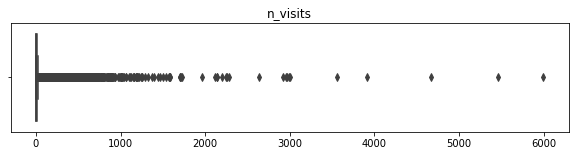

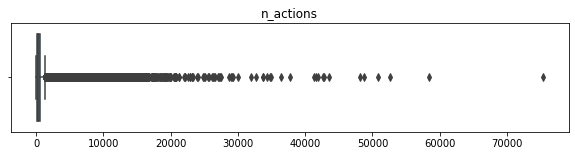

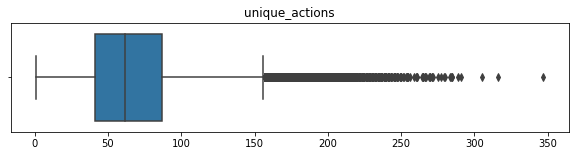

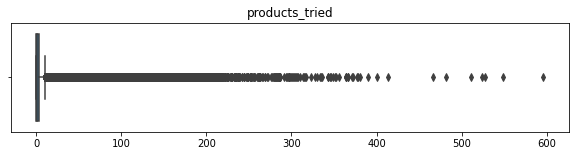

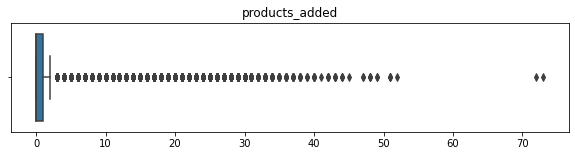

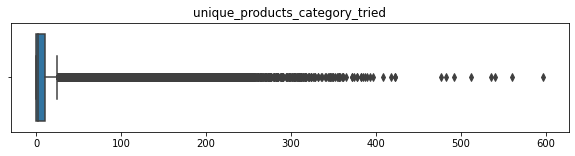

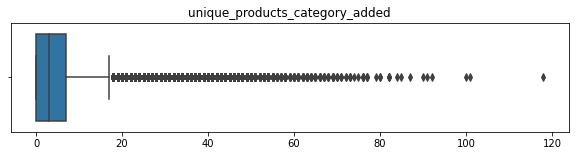

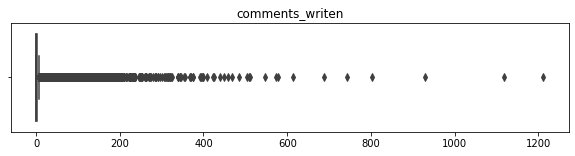

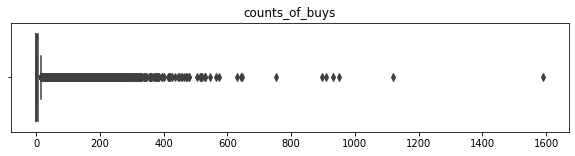

In [9]:
plot_outliers(df_num)

Boxplots show that all numerica variables has outliers. But do we need to remove all of them or not. Let's see correlation matrix before decision.

In [10]:
corr = df.corr()
corr.sort_values('came_back',ascending=False)[['came_back']]

,came_back
came_back,1.000000
unique_actions,0.476349
unique_products_category_added,0.404911
n_actions,0.382764
saved_to_cart,0.359353
counts_of_buys,0.308266
comments_writen,0.285344
unique_products_category_tried,0.245592
products_added,0.240403
n_visits,0.180687


<Axes: >

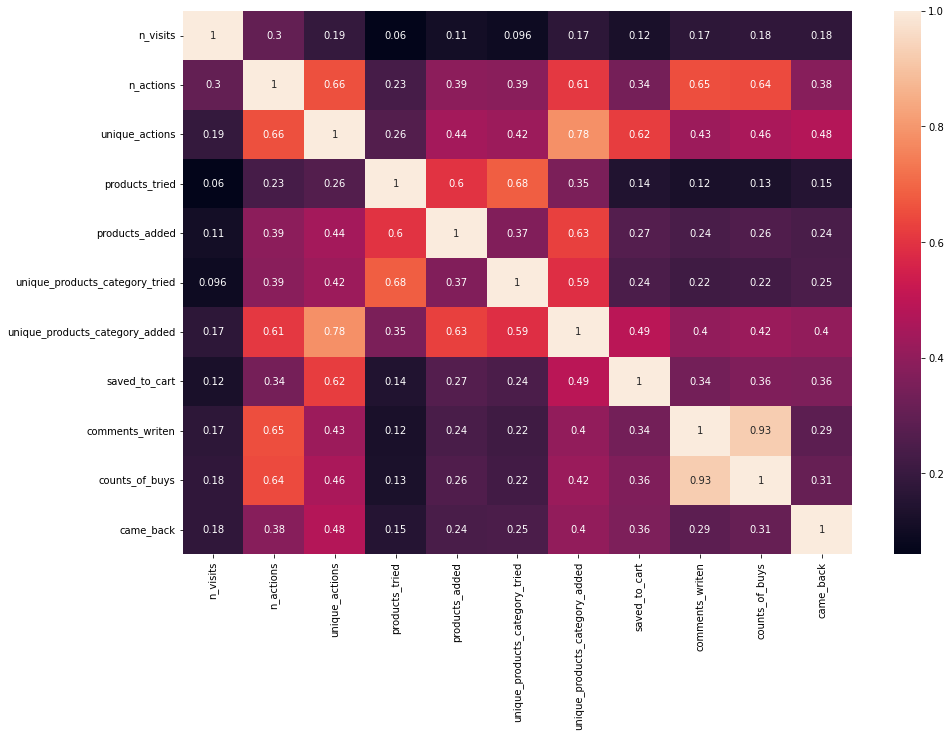

In [11]:
plt.figure(figsize=(15,10))
sns.heatmap(corr,annot=True)


## KNN

In [44]:
def knn_grid_search(df,ks = [3,5,7,11,15]):  
    X_train,X_test,y_train,y_test = train_test_split(df.drop("came_back",axis=1),df['came_back'],test_size=0.1,random_state=123)
    knn = Pipeline([
        ('scaler',StandardScaler()),
        ('knn',KNeighborsClassifier())
    ])

    knn_params = {'knn__n_neighbors':ks}

    knn_grid_search = GridSearchCV(
            knn,
            knn_params,
            cv=5,
            verbose=True
    )
    
    knn_grid_search.fit(X_train,y_train)
    
    return knn_grid_search

In [14]:
knn_grid_search = knn_grid_search(df)
cv_results_1 = knn_grid_search.cv_results_

Fitting 5 folds for each of 5 candidates, totalling 25 fits


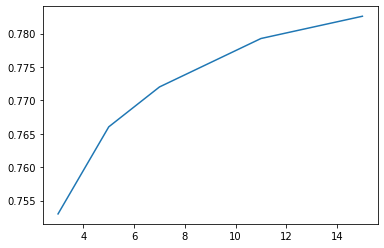

In [36]:
ks = []

mean_scores_1 = cv_results_1['mean_test_score']

for i in range(len(cv_results_1['params'])):
    ks.append(list(cv_results_1['params'][i].values())[0])
    
plt.plot(ks,mean_scores_1)

Remove ouliers

In [37]:
def remove_outliers(data,whis = 1.5):
    
    df = data.copy()
    
#     outliers dictionary contains outlier indexes for each feature
    outliers = {}
    
#     this set contains total outliers in a data frame
    total_outlier_indexes = set()
    
#     this set contains indexes where all features has outliers
    total_outlier_intersect = set()
    
    for column in df:
        
        q_1 = np.percentile(df[column],25)
        q_3 = np.percentile(df[column],75)
        
        IQR = q_3 - q_1
        
        outs = df[[column]][(df[column] < q_1 - whis*IQR) | (df[column] > q_3 + whis*IQR)].index.tolist()
        outliers[column] = outs
        total_outlier_indexes = total_outlier_indexes.union(set(outs))
        
    
    return df.drop(total_outlier_indexes), outliers,total_outlier_indexes

    

    
    

In [42]:
df_without_outliers,total_outliers = remove_outliers(df)[0],remove_outliers(df)[2]
df_without_outliers.index = range(df.shape[0] - len(total_outliers))

df_without_outliers.to_csv("data_without_outliers.csv")



In [45]:
knn_grid_search_2 = knn_grid_search(df_without_outliers)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


In [46]:
cv_results_2 = knn_grid_search_2.cv_results_

(0.74, 0.83)

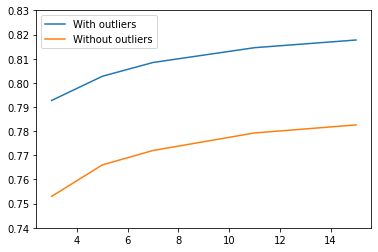

In [47]:
mean_score_2 = cv_results_2['mean_test_score']

plt.plot(ks,mean_score_2,label="With outliers")
plt.plot(ks,mean_scores_1,label="Without outliers")

plt.legend()

plt.ylim(.74,.83)

KNN model with data without ouliters performs better than with outliers. But what if there is any outliers yet.
Now we can check if there are any outliers new outliers after removing 'old' outliers. If yes, we can perform for loop and remove outliers several times․

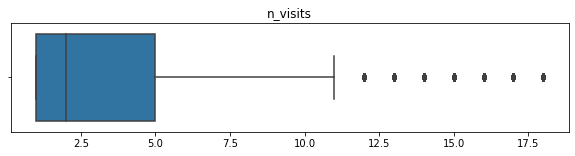

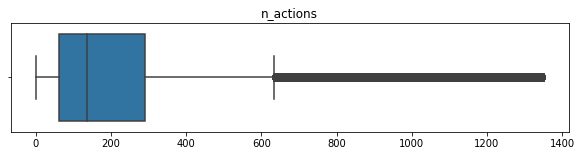

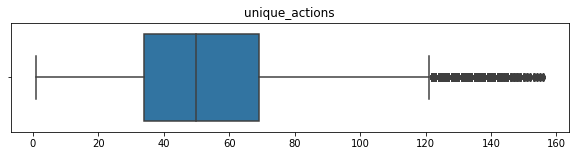

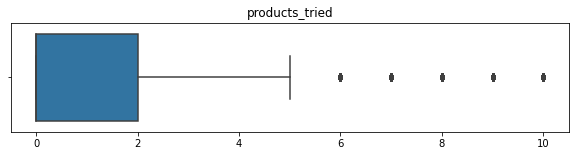

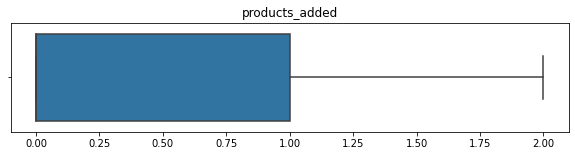

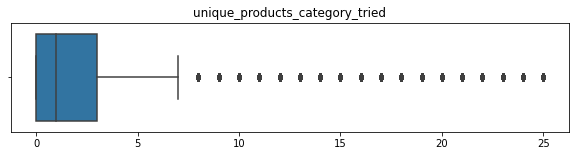

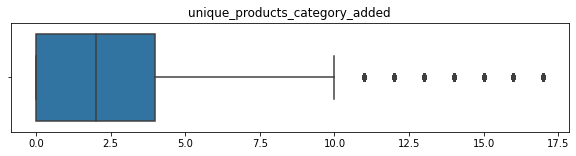

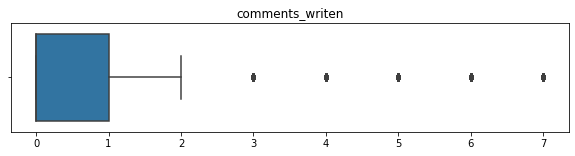

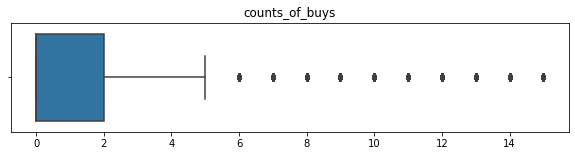

In [48]:
plot_outliers(df_without_outliers.drop(['saved_to_cart','came_back'],axis=1))

Let's   remove one more time all outliers and see the result, but this time let set whis equal to 3 (3 * IQR).

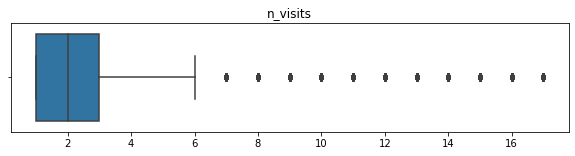

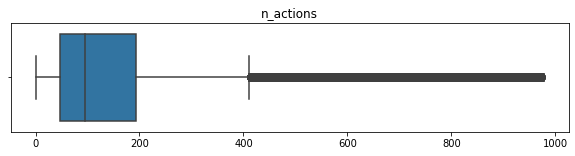

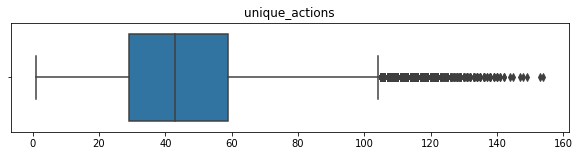

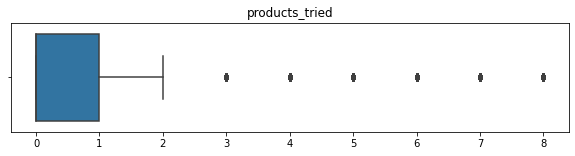

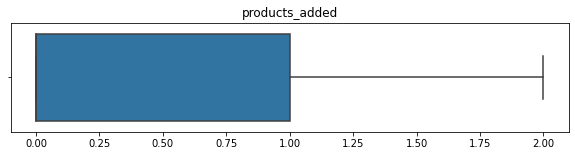

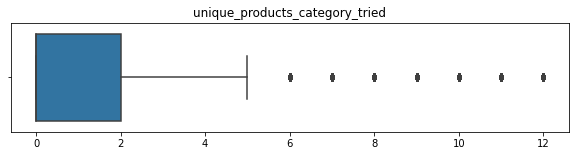

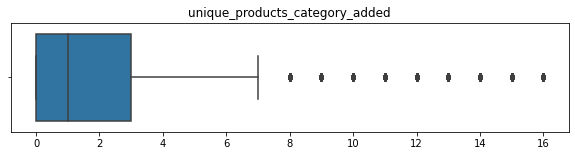

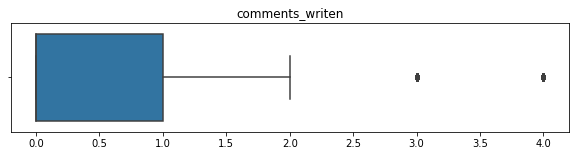

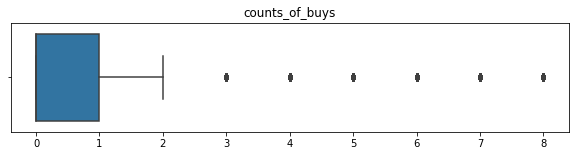

In [50]:
new_df,outliers_2,_ = remove_outliers(df_without_outliers,whis=3)
plot_outliers(new_df.drop(['saved_to_cart','came_back'],axis=1))

Visully we can see that the most outliers have 'n_actions' and 'unique_actions' features. Let's count exact amounts.
But before it, we can build a model using this data set with best K parameter from previous grid search result.

In [51]:
# from KNN grid search we have best k parameter
best_k = list(knn_grid_search_2.best_params_.values())[0]
best_k

15

In [52]:
def my_KNN(df,k=best_k):
    
    model_results = {}
    
    X_train,X_test,y_train,y_test = train_test_split(df.drop("came_back",axis=1),df['came_back'],test_size=0.1,random_state=123)
       
    model = KNeighborsClassifier(k)
    model.fit(X_train,y_train)
    prediction = model.predict(X_test)
    model_results['classification_report'] = classification_report(y_test,prediction)
    model_results['f1_score'] = f1_score(y_test,prediction)
    model_results['accuracy'] = model.score(X_test,y_test)
    
    return model_results
    


In [53]:
model_1_results = my_KNN(new_df,k=best_k)  

C:\Users\New User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


In [54]:
print(model_1_results['classification_report'])

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     31599

    accuracy                           1.00     31599
   macro avg       1.00      1.00      1.00     31599
weighted avg       1.00      1.00      1.00     31599



**Accuracy is one, because second time we removed outliers all observations with zero labels were removed.
So, it bad idea to remove outlier second time.**

In [55]:
new_df['came_back'].value_counts()

0    315990
Name: came_back, dtype: int64

In [57]:
y = df_without_outliers['came_back']
test_size_ = 0.1


X_train,X_test,y_train,y_test = train_test_split(df_without_outliers.drop('came_back',axis=1),y,test_size=test_size_,random_state=1234)


# standard and normal data

scaler = StandardScaler()


X = np.empty((df_without_outliers.drop('came_back',axis=1)).shape)

X[:,:9] = scaler.fit_transform(df_without_outliers.drop(['saved_to_cart','came_back'],axis=1))
X[:,-1] = df_without_outliers['saved_to_cart']

# StandardScaler
X_train_scaled,X_test_scaled,y_train_scaled,y_test_scaled = train_test_split(X,y,test_size=test_size_,random_state=1234)



# sigmoid
def sigmoid(x):
    return 1/(1+np.exp(-x))

df_sigmoid = df_without_outliers.copy()

df_sigmoid = df_sigmoid.apply(lambda x: sigmoid(x) if len(np.unique(x)) >2 else x)


X_sigm = df_sigmoid.drop('came_back',axis=1).to_numpy()

# sigmoid
X_train_sigm,X_test_sigm,y_train_sigm,y_test_sigm = train_test_split(X_sigm,y,random_state=123,test_size=test_size_)



In [58]:
# write to csv

num_columns = list(df_num.columns)
num_columns.append('saved_to_cart')
scaled_data = pd.DataFrame(data=X,columns=num_columns)
scaled_data['came_back'] = df_without_outliers['came_back']

df_sigmoid.to_csv("sigmoid_data.csv")
scaled_data.to_csv("StandardScaler.csv")

df_sigmoid.shape,scaled_data.shape



((436415, 11), (436415, 11))

**Manual KNN**

In [59]:
def KNN_manual(df,ks=[5,10,15,20,25,30]):
    
    X_train,X_test,y_train,y_test = train_test_split(df.drop("came_back",axis=1),df['came_back'],test_size=0.1,random_state=123)
     
    scores = []
    
    for k in ks:
        model = KNeighborsClassifier(k)
        model.fit(X_train,y_train)
        score = (model.score(X_test,y_test))
        scores.append(score)
        print(F"\tk: {k} -> accuracy: {score}")
    
    return scores,ks

In [60]:
print("Non startardized data:\n")
scores_normal,ks = KNN_manual(df_without_outliers)

print("\n\nSigmoid data:\n")
scoes_sigmoid,ks = KNN_manual(df_sigmoid)

print("\n\nStandardScaler:\n")
scores_stscaled,ks = KNN_manual(scaled_data)

Non startardized data:

	k: 5 -> accuracy: 0.8009028000549929
	k: 10 -> accuracy: 0.8126346180285047
	k: 15 -> accuracy: 0.8155904862288621
	k: 20 -> accuracy: 0.8165070345080427
	k: 25 -> accuracy: 0.816873653819715
	k: 30 -> accuracy: 0.8186838366710967


Sigmoid data:

	k: 5 -> accuracy: 0.797351175473168
	k: 10 -> accuracy: 0.8126575317354842
	k: 15 -> accuracy: 0.81474267907062
	k: 20 -> accuracy: 0.8176527198570185
	k: 25 -> accuracy: 0.8169882223546125
	k: 30 -> accuracy: 0.8189129737408918


StandardScaler:

	k: 5 -> accuracy: 0.801750607213235
	k: 10 -> accuracy: 0.8159112781265753
	k: 15 -> accuracy: 0.8191191971037074
	k: 20 -> accuracy: 0.8213876540946794
	k: 25 -> accuracy: 0.8224875120296962
	k: 30 -> accuracy: 0.8239539892763851


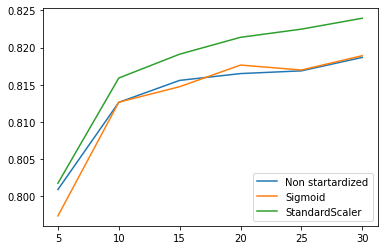

In [61]:
plt.plot(ks,scores_normal,label = "Non startardized")
plt.plot(ks,scoes_sigmoid,label="Sigmoid")
plt.plot(ks,scores_stscaled,label="StandardScaler")

plt.legend()
plt.show()

In [63]:
# print("Non startardized data:\n")
# scores_normal_2,ks = KNN_manual(df_without_outliers,list(range(10,31)))

# print("\n\nSigmoid data:\n")
# scoes_sigmoid_2,ks = KNN_manual(df_sigmoid,list(range(10,31)))

# print("\n\nStandardScaler:\n")
# scores_stscaled_2,ks = KNN_manual(scaled_data,list(range(10,31)))

In [ ]:
# plt.plot(ks,scores_normal_2,label = "Non startardized")
# plt.plot(ks,scoes_sigmoid_2,label="Sigmoid")
# plt.plot(ks,scores_stscaled_2,label="StandardScaler")

# plt.legend()
# plt.show()

In [64]:
best_k = 21

## Decision Tree

In [65]:
X_train.shape,y_train.shape

((392773, 10), (392773,))

In [66]:
def grid_search_tree(X_train,y_train):
    
    pipeline = Pipeline([
        ("scaler",StandardScaler()),
        ("model",DecisionTreeClassifier())
    ])
    
    tree_params = {"model__criterion":["gini","entropy","log_loss"],
                   "model__max_depth":[3,5,7,9,11]}    
    grid_search = GridSearchCV(
                    pipeline,
                    tree_params,
                    cv=5)
    
    grid_search.fit(X_train,y_train)
    return grid_search

In [67]:
grid_search_tree_normal = grid_search_tree(X_train,y_train)
grid_search_tree_sigmoid = grid_search_tree(X_train_sigm,y_train_sigm)
grid_search_tree_scaled = grid_search_tree(X_train_scaled,y_train_scaled)

In [68]:
print(grid_search_tree_normal.score(X_test,y_test))
print(grid_search_tree_sigmoid.score(X_test_sigm,y_test_sigm))
print(grid_search_tree_scaled.score(X_test_scaled,y_test_scaled))

0.8251684157462994
0.8242060400531598
0.8251684157462994


In [69]:
# save best tree model
dump(grid_search_tree_scaled,"decision_tree.pkl")

['decision_tree.pkl']

In [70]:
tree_mean_normal = grid_search_tree_normal.cv_results_['mean_test_score']
tree_mean_sigmoid = grid_search_tree_sigmoid.cv_results_['mean_test_score']
tree_mean_scaled = grid_search_tree_scaled.cv_results_['mean_test_score']

In [ ]:
grid_search_tree_normal.cv_results_

## Logistic regression

In [ ]:
log_pipeline = Pipeline([
    ("sclaer",StandardScaler()),
    ("model",LogisticRegression())
])

log_pipeline.get_params()

In [ ]:
log_params = {"model__penalty":['l1','l2','elasticent',None],
              "model__max_iter":[100,1000,10000],
              "model__solver":['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
              }

log_grid_search = GridSearchCV(log_pipeline,log_params,cv=5)


In [ ]:
# log_normal = log_grid_search.fit(X_train,y_train)
# log_sigmoid = log_grid_search.fit(X_train_sigm,y_train_sigm)
# log_scaled = log_grid_search.fit(X_train_scaled,y_train_scaled)

In [ ]:
# log_normal.score(X_test,y_test)
# log_sigmoid.score(X_test_sigm,y_test_sigm)
# log_scaled.score(X_test_scaled,y_test_scaled)

In [ ]:
LogisticRegression().fit(X_train_scaled,y_train_scaled).score(X_test_scaled,y_test_scaled),LogisticRegression().fit(X_train_sigm,y_train_sigm).score(X_test_sigm,y_test_sigm)

# Bayesian Inference

In [71]:
naive_models = [GaussianNB, BernoulliNB, CategoricalNB, ComplementNB, MultinomialNB]

In [75]:
for i in np.linspace(0.001,1,15,endpoint=False):
    i = round(i,3)
    j = round(1-i,3)
    priors = [i,j]
    Gaussian = GaussianNB(priors = priors).fit(X_train_scaled,y_train_scaled)
    Bernouli = BernoulliNB(class_prior=priors).fit(X_train_scaled,y_train_scaled)
    Complement = ComplementNB(class_prior=priors).fit(X_train_sigm,y_train_sigm)
    Multinomial = MultinomialNB(class_prior=priors).fit(X_train_sigm,y_train_sigm)
    
    print(f"priors:{priors}, Gaussian: {round(Gaussian.score(X_test_scaled,y_test_scaled),3)}\
            Bernoulli:  {round(Bernouli.score(X_test_scaled,y_test_scaled),3)}\
            Complement: {round(Complement.score(X_test_sigm,y_test_sigm),3)}\
            Multinomial: {round(Multinomial.score(X_test_sigm,y_test_sigm),3)}")

priors:[0.001, 0.999], Gaussian: 0.304            Bernoulli:  0.197            Complement: 0.664            Multinomial: 0.198
priors:[0.068, 0.932], Gaussian: 0.669            Bernoulli:  0.602            Complement: 0.664            Multinomial: 0.198
priors:[0.134, 0.866], Gaussian: 0.699            Bernoulli:  0.642            Complement: 0.664            Multinomial: 0.198
priors:[0.201, 0.799], Gaussian: 0.713            Bernoulli:  0.651            Complement: 0.664            Multinomial: 0.198
priors:[0.267, 0.733], Gaussian: 0.723            Bernoulli:  0.666            Complement: 0.664            Multinomial: 0.198
priors:[0.334, 0.666], Gaussian: 0.732            Bernoulli:  0.673            Complement: 0.664            Multinomial: 0.198
priors:[0.401, 0.599], Gaussian: 0.739            Bernoulli:  0.681            Complement: 0.664            Multinomial: 0.198
priors:[0.467, 0.533], Gaussian: 0.745            Bernoulli:  0.697            Complement: 0.664            Mul

# Save models

In [76]:
X_train,y_train = scaled_data.drop("came_back",axis=1),scaled_data['came_back']

In [77]:
KNN = KNeighborsClassifier(best_k).fit(X_train,y_train)
dump(KNN,"knn.pkl")

['knn.pkl']

In [78]:
tree = grid_search_tree_scaled.best_estimator_.fit(X_train,y_train)
dump(tree,"tree.pkl")

['tree.pkl']

In [79]:
logistic_regression = LogisticRegression().fit(X_train,y_train)
dump(tree,"logistic.pkl")

['logistic.pkl']

In [80]:
naive_bayes = GaussianNB(priors=[0.98,.02]).fit(X_train,y_train)
dump(naive_bayes,"naive_bayes.pkl")

['naive_bayes.pkl']